# 3. Hull-White Model and Interest Rate Derivatives

이번 강의에서는 이자율 파생상품의 가격결정에 사용되는 Hull White Model에 대해 공부하고 이를 활용해 이자율 파생상품의 가격을 결정합니다.

## 1. Hull-White Model에 대한 설명

Hull White Model(HW model)은 미래의 금리를 설명하는 모형으로, 금리의 평균회귀성을 고려한 모형입니다. 해당 모형은 Short rate Model로, 미래의 시점 $t$에서 그 잠시 후의 시점인 $t+dt$ 사이의 짧은 시간 동안 적용되는 금리에 대한 모형입니다. HW model에 따르면 $t$시점에서의 단기금리 $r(t)$는 다음과 같은 움직임을 보입니다.
<br>
$$dr(t) = \kappa(\theta (t)-r(t))dt + \sigma dW$$
이때 $\theta (t)$는 $t$시점에서의 단기금리의 평균이고, $\kappa$는 회귀계수입니다.<br>
즉, 단기금리의 움직임은 평균회귀와 난수의 합으로 정해진다는 것입니다. 위의 모형은 one-factor HW model이라고도 불리며, 다음과 같은 two-factor HW model 또한 존재합니다.
<br>
$$r(t) = x(t) + y(t) + \theta (t)$$
$$dx(t) = -{k_x}x(t)dt + {\sigma_x} dW_1$$
$$dy(t) = -{k_y}y(t)dt + {\sigma_y} dW_2$$
$$Cov(dW_1, dW_2) = \rho$$
<br>
해당 모형을 사용하여 몬테카를로 시뮬레이션을 실행하면, 미래 특정 시점에서의 단기금리의 분포를 근사할 수 있으며, 미래 시점에서 단기금리에 따라 수익률이 정해지는 이자율 파생상품의 가격 결정을 실행할 수 있습니다.<br>
하지만 현실에는 $dt$라는 아주 짧은 기간동안 정의되는 초단기 금리는 존재하지 않습니다. 그래서 이러한 단기금리를 기초자산으로 가지는 국내 이자율 파생상품은 CD 91일물 금리를 사용합니다.

## 2. Hull-White Model 설정
HW model의 $\theta$는 다음과 같이 정의됩니다.<br>
$$\theta (t) = {{\partial f^M}\over{\partial t}}(0,t) + \kappa f^M (0,t) + {{\sigma^2}\over{2\kappa}}(1-e^{-2\kappa t}) $$<br>
이때, $f^M(0,t)$는 0 시점에서 추정한 $(t,t+dt)$기간의 선도금리입니다.<br>
우선 모형 설정을 위해, 현물 이자율부터 도출합니다. 현물 이자율 도출을 위해 CD91일물 금리를 기초자산으로 가지는 이자율스왑을 이용합니다. 현재 CD91일 금리는 3.52%이고 3개월마다 이자를 교환하는 이자율스왑 금리는 다음과 같습니다.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
IRS = pd.read_excel("IRS.xlsx")
IRS["IRS금리"]/=100

In [3]:
IRS

,만기(년),IRS금리
0,1,0.030750
1,2,0.028575
2,3,0.027950
3,4,0.027850
4,5,0.027875
5,7,0.027975
6,10,0.028275
7,12,0.028450
8,15,0.028400
9,20,0.027475


현물이자율 데이터프레임을 제작합니다.

In [4]:
ZR = pd.DataFrame(index = range(1,81),columns = ["R(t)"])
ZR.index/=4
ZR.iloc[0] = 0.0352
ZR["R(t)"] = pd.to_numeric(ZR["R(t)"])

이제 두 시점과 해당 시점들에서의 현물이자율이 정해질 때, 두 시점 사이에서의 선도금리를 구하는 함수를 만들고, IRS금리가 현재 데이터와 같아지는 현물이자율 곡선을 도출합니다. 이때, 순간 선도금리 곡선과 그 미분까지 이용해야 하기 때문에 이전과 달리 할인계수를 보간하기로 합니다.

In [5]:
def findforward(T,S,RT,RS):
    if (S<=T):
        return -999
    DF1 = np.exp(-T*RT)
    DF2 = np.exp(-S*RS)
    DFratio = DF1/DF2
    return (DFratio - 1)/(S-T)

def linearprice(rate,ZR,T,irs):
    Zero = ZR.iloc[0:T*4].copy()
    Zero.loc[T][0] = rate
    Zero["DF"] = np.exp(-Zero.index*Zero["R(t)"])
    Zero["DF"] = pd.to_numeric(Zero["DF"])
    Zero["DF"] = Zero["DF"].interpolate()
    Zero["R(t)"] = -np.log(Zero["DF"])/Zero.index
    floatleg = Zero.iloc[0,0]*Zero.iloc[0,1]
    fixleg = irs*Zero.iloc[0,1]
    for i in range(1,Zero.shape[0]-2):
        floatleg += findforward(Zero.index[i],Zero.index[i+1],Zero["R(t)"].iloc[i],Zero["R(t)"].iloc[i+1])*Zero.iloc[i+1,1]
        fixleg += irs*Zero.iloc[i+1,1]
    return fixleg-floatleg
    

In [6]:
for i in range(0,10):
    T = IRS.iloc[i,0]
    irs = IRS.iloc[i,1]
    r = scipy.optimize.fsolve(linearprice,irs,args = (ZR,T,irs))[0]
    ZR.loc[T,"R(t)"] = r
    ZR["DF"] = np.exp(-ZR.index*ZR["R(t)"])
    ZR["DF"] = pd.to_numeric(ZR["DF"])
    ZR["DF"].loc[:T] = ZR["DF"].loc[:T].interpolate()
    ZR["R(t)"] = -np.log(ZR["DF"])/ZR.index

이제 구한 현물이자율을 바탕으로 각 시점에서의 순간선도금리를 구하고, 그것을 차분하여 순간선도금리의 미분함수를 구합니다.

In [7]:
ZRall = pd.DataFrame(index = range(1,252*20+1),columns = ["R(t)"])
Ft = pd.DataFrame(index = range(1,252*20+1),columns = ["F(t)"])
dFt = pd.DataFrame(index = range(1,252*20+1),columns = ["dF(t)"])
ZRall.index/=252
Ft.index/=252
dFt.index/=252

In [8]:
for i in range(0,ZR.shape[0]):
    T = ZR.index[i]
    R = ZR.loc[T][0]
    ZRall.loc[T][0] = R

In [9]:
ZRall["R(t)"] = pd.to_numeric(ZRall["R(t)"])

In [10]:
ZRall = ZRall.interpolate(method="polynomial",order = 3)

In [11]:
ZRall.iloc[0,0] = 0.0352
ZRall = ZRall.interpolate(method = 'index')

In [12]:
for i in range(0,ZRall.shape[0]-1):
    T = ZRall.index[i]
    S = ZRall.index[i+1]
    RT = ZRall.loc[T][0]
    RS = ZRall.loc[S][0]
    Ft.loc[T][0] = findforward(T,S,RT,RS)
for i in range(0,ZRall.shape[0]-2):
    T = Ft.index[i]
    S = Ft.index[i+1]
    RT = Ft.loc[T][0]
    RS = Ft.loc[S][0]
    dFt.loc[T][0] = (RS-RT)/(T-S)

$\kappa = 0.1$, $\sigma = 0.01$으로 설정 후 $\theta$를 구합니다.

In [13]:
theta = pd.DataFrame(index = range(1,252*20+1),columns = ["theta"])
theta.index/=252
kappa = 0.1
sigma = 0.01

In [14]:
theta["theta"] = dFt["dF(t)"] + kappa*Ft["F(t)"]+(sigma**2/(2*kappa))*(1-np.exp(-2*kappa*theta.index))

## 3. Monte Carlo Simulation with Hull-White Model

이제 구한 $\theta$를 이용하여 몬테카를로 시뮬레이션을 실행하면 이자율 파생상품의 적정가치를 계산할 수 있습니다.<br> MC를 이용하여 다음과 같은 DLB의 가격결정을 시행합니다.<br>
원금 : 10000<br>
만기 : 2년<br>
기초자산 : CD 91일물 금리<br>
수익률 : 만기시점 기초자산이 3% 이상일 경우 5%, 4% 이하일 경우 3%<br>

In [15]:
r0 = 0.0352
T = 2
days = 252
nsimulation = 10000

In [16]:
Normal = np.random.normal(size=(T*days, nsimulation))

In [17]:
path = np.zeros((T*days+1,nsimulation))
path[0] = r0

In [18]:
dt = 1/252

In [19]:
for i in range(1,T*days+1):
    path[i] = path[i-1]+kappa*(theta.iloc[i-1,0]-path[i-1])*dt + sigma*np.sqrt(dt)*Normal[i-1]

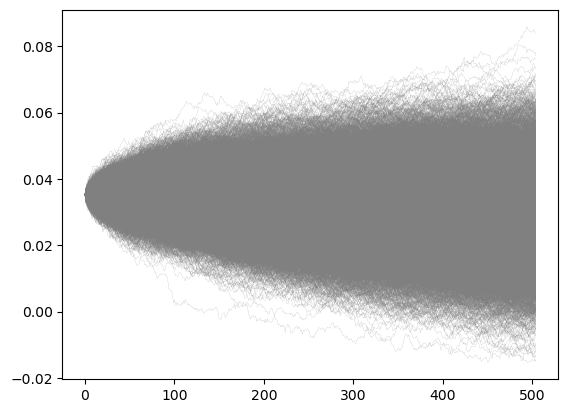

In [20]:
plt.plot(path,color = "gray",linewidth = "0.1")
plt.show()

이제 만기 시점에서 금리가 4% 이상인 경우 11000원을, 아닐 경우 10600원을 지급하게 설정한 후, 현물이자율을 통해 현재가치를 구하면 DLB의 현재가치를 구할 수 있습니다.

In [21]:
up = np.sum(1*(path[252]>0.03))
down = nsimulation-up

In [22]:
price = ((11000*up + 10600*down)/10000)*ZR.loc[2.00,"DF"]

In [23]:
price

10254.460664122624

## 4. Trinomial Tree with Hull-White Model

HW 모형을 이용해 파생상품의 가치평가를 하는 방법은 MC 이외에 삼항트리가 있습니다. 삼항트리를 통해 파생상품 가치평가를 하는 방법은 다음과 같습니다.<br>

1.만기까지의 구간$[0,T]$를 $N$개의 동일구간으로 나눕니다

2.$[t_M,t_{M+1}]$동안 적용되는 이자율 $R(t)$을 도입합니다.

3.금리가 상승할 수 있는 최고점 $R_{max}$와 하락할 수 있는 최저점 $R_{min}$을 설정합니다.

4.추세항이 없는 이자율의 확률과정을 생성하고, 각 노드에서 상승, 하락, 유지 시의 이자율을 구하고 그 확률을 계산합니다. 단, 상한에서는 확률과정이 (유지, 하락, 2단계 하락) 으로 재정의 되며 하한에서도 동일하게 재정의됩니다.

5.위에서 만든 노드에 추세항을 더해 각 노드에서의 이자율과 그 노드로 도달할 확률을 계산하여 이자율 파생상품의 가격을 구합니다.

삼항트리와 몬테카를로 시뮬레이션의 차이점으로 두드러지는 것은, 삼항트리는 단기금리가 아닌 기간동안 적용되는 금리를 시뮬레이션하고, 삼항트리는 이자율의 상한과 하한을 설정한다는 것입니다.<br>

위에서 정의한 상품을 계산하기 위해 $\Delta t = 0.25$로 정의하고, $R_{max},R_{min}$은 각각 추세항에서 두 번 연속으로 상승했을 때와, 두 번 연속 하락했을 때로 정의합니다. 그리고 각 노드에서 상승과 하락시 이자율 변화량 $\Delta R$은 다음과 같이 정의합니다.<br>
$$\Delta R = \sigma \sqrt{3\Delta t} $$

In [24]:
dr = sigma*np.sqrt(3*0.25)

이제 각 노드에서 다음 시점에서의 이자율의 기댓값과 분산을 이론적인 기댓값, 분산과 일치시키는 상승, 유지, 하락 확률을 구합니다. pnu, pnd는 상한, 하한이 아닌 일반적인 노드에서 각각 상승, 하락 확률이고, psu, psd는 상한에서의 유지, 2단계 하락의 확률, piu, pid는 하한에서의 2단계 상승, 유지의 확률입니다.

In [25]:
def pnu(kappa,j,dt):
    k = kappa*j*dt
    return 1/6 + (k**2-k)/2
def pnd(kappa,j,dt):
    k = kappa*j*dt
    return 1/6 + (k**2 + k)/2
def pnm(kappa,j,dt):
    return 1-pnu(kappa,j,dt)-pnd(kappa,j,dt)

def psu(kappa,j,dt):
    k = kappa*j*dt
    return 7/6 + (k**2 - 3*k)/2
def psd(kappa,j,dt):
    k = kappa*j*dt
    return 1/6 + (k**2 - k)/2
def psm(kappa,j,dt):
    return 1-psu(kappa,j,dt)-psd(kappa,j,dt)

def piu(kappa,j,dt):
    k = kappa*j*dt
    return 1/6 + (k**2 + 3*k)/2
def pid(kappa,j,dt):
    k = kappa*j*dt
    return 7/6 + (k**2 + k)/2
def pim(kappa,j,dt):
    return 1-piu(kappa,j,dt)-pid(kappa,j,dt)

이제 추세항이 없는 금리 노드를 나타내는 데이터프레임과 그 시점에서의 금리가 해당 노드의 금리일 확률을 나타내는 데이터프레임을 만듭니다.

In [26]:
rate = pd.DataFrame(index = ['uu','u',0,'d','dd'], columns = range(0,9))
IRprob= pd.DataFrame(index = ['uu','u',0,'d','dd'], columns = range(0,9))
rate.columns/=4
IRprob.columns/=4

In [27]:
rate.iloc[2,0] = 0
IRprob[0] = 0
IRprob.iloc[2,0] = 1

In [28]:
rate.loc[0] = 0
rate.loc['uu'] = 2*dr
rate.loc['u'] = dr
rate.loc['dd'] = -2*dr
rate.loc['d'] = dr
rate[0] = 0

In [29]:
rate

,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00
uu,0,0.017321,0.017321,0.017321,0.017321,0.017321,0.017321,0.017321,0.017321
u,0,0.00866,0.00866,0.00866,0.00866,0.00866,0.00866,0.00866,0.00866
0,0,0,0,0,0,0,0,0,0
d,0,0.00866,0.00866,0.00866,0.00866,0.00866,0.00866,0.00866,0.00866
dd,0,-0.017321,-0.017321,-0.017321,-0.017321,-0.017321,-0.017321,-0.017321,-0.017321


In [30]:
for i in range(1,9):
    IRprob.iloc[0,i] = psu(kappa,2,0.25)*IRprob.iloc[0,i-1] + pnu(kappa,1,0.25)*IRprob.iloc[1,i-1]
    IRprob.iloc[1,i] = pnu(kappa,0,0.25)*IRprob.iloc[2,i-1] + psm(kappa,2,0.25)*IRprob.iloc[0,i-1] + pnm(kappa,1,0.25)*IRprob.iloc[1,i-1]
    IRprob.iloc[2,i] = pnm(kappa,0,0.25)*IRprob.iloc[2,i-1] + psd(kappa,2,0.25)*IRprob.iloc[0,i-1] + pnd(kappa,1,0.25)*IRprob.iloc[1,i-1]
    IRprob.iloc[2,i] += pnu(kappa,-1,0.25)*IRprob.iloc[3,i-1]+piu(kappa,-2,0.25)*IRprob.iloc[4,i-1]
    IRprob.iloc[3,i] = pnd(kappa,0,0.25)*IRprob.iloc[2,i-1] + pnm(kappa,-1,0.25)*IRprob.iloc[3,i-1]+pim(kappa,-2,0.25)*IRprob.iloc[4,i-1]
    IRprob.iloc[4,i] = pid(kappa,-2,0.25)*IRprob.iloc[4,i-1]+pnd(kappa,-1,0.25)*IRprob.iloc[3,i-1]

In [31]:
IRprob

,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00
uu,0,0.0,0.025747,0.062451,0.103153,0.144571,0.185162,0.224204,0.261367
u,0,0.166667,0.222118,0.225913,0.20607,0.175802,0.14136,0.105715,0.070285
0,1,0.666667,0.504271,0.421984,0.377264,0.350179,0.331385,0.316494,0.303442
d,0,0.166667,0.222118,0.225913,0.205766,0.174516,0.13806,0.099066,0.058707
dd,0,0.0,0.025747,0.063739,0.107747,0.154932,0.204034,0.254521,0.3062


이제 추세항과 HW model을 적용시킨 금리를 구합니다.

In [32]:
IRrate = pd.DataFrame(index = ['uu','u',0,'d','dd'], columns = range(0,9))
IRrate.columns/=4

In [33]:
IRrate[0] = 0
IRrate.iloc[2,0] = r0

In [34]:
IRrate.iloc[1,1] = r0+rate.iloc[1,1]
IRrate.iloc[2,1] = r0+rate.iloc[2,1]
IRrate.iloc[3,1] = r0+rate.iloc[3,1]

In [35]:
for i in range(2,9):
    thetat = theta.loc[(i-1)*0.25][0]
    drift = kappa*(thetat-IRrate.iloc[2,i-1])+IRrate.iloc[2,i-1]
    IRrate.iloc[0,i] = drift+rate.iloc[0,i]
    IRrate.iloc[1,i] = drift+rate.iloc[1,i]
    IRrate.iloc[2,i] = drift+rate.iloc[2,i]
    IRrate.iloc[3,i] = drift+rate.iloc[3,i]
    IRrate.iloc[4,i] = drift+rate.iloc[4,i]

In [36]:
IRrate

,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00
uu,0.0000,NaN,0.052483,0.048747,0.046325,0.042852,0.040775,0.038627,0.036439
u,0.0000,0.04386,0.043823,0.040087,0.037665,0.034191,0.032115,0.029967,0.027779
0,0.0352,0.0352,0.035163,0.031427,0.029005,0.025531,0.023455,0.021306,0.019119
d,0.0000,0.04386,0.043823,0.040087,0.037665,0.034191,0.032115,0.029967,0.027779
dd,0.0000,NaN,0.017842,0.014106,0.011684,0.008211,0.006134,0.003986,0.001798


만기에서 3% 이상의 금리는 상한에서의 금리밖에 없으므로 만기에서 5%의 금리가 적용될 확률은 금리의 상한에 도달할 확률인 26%이며 이를 통한 DLB의 가격은 다음과 같습니다.

In [37]:
price = ((11000*IRprob.iloc[0,-1] + 10600*(1-IRprob.iloc[0,-1])))*ZR.loc[2.00,"DF"]

In [39]:
price

10119.192099338876